In [1]:
#load packages

import math, time
import torch
import os
import sys
sys.path.append('../..')
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
#CHOOSE DATA PATH AND NAME
DATA_PATH = './data/' #change this to your data path
dataname = '2dgaussian_diffmag' #change this to your data name

In [ ]:

from functions.get_data import data_n_loaders
# LAB_DIR = os.environ['USERDIR']
# DATA_PATH = LAB_DIR+'/data'

#load data subset
batch_size = 512 #doesn't matter for this, just need to load data
_, _,train_data, _, mean, scale = data_n_loaders(dataname, batch_size, return_data=True, \
      data_path=DATA_PATH, standardise_data = True, return_transform=True)
mean = mean.squeeze()
train_data_raw = (train_data.data/scale) + mean

#sample equal number of points from each concept
torch.manual_seed(0)
numpoints_perconcept = 1000
num_concepts = 6
data_subset_perconcept = []
labels_subset_perconcept = []
for i in range(num_concepts):
    indices = train_data.labels == i
    rand_indices_i = torch.randperm(indices.sum())[:numpoints_perconcept]
    data_subset_perconcept.append(train_data_raw[indices][rand_indices_i])
    labels_subset_perconcept.append(train_data.labels[indices][rand_indices_i])
data_subset_raw = torch.cat(data_subset_perconcept, dim=0)
data_subset = (data_subset_raw - mean) * scale #transform same as training data (to input to model)
labels_subset = torch.cat(labels_subset_perconcept, dim=0)
datavar = data_subset.var(dim=0).sum().item()
mean_norm2_data = (data_subset**2).sum(dim=-1).mean().item()

/n/home00/sumedh/spmax_sae/experiments/expt19_separability_diffmag2/../../functions/get_data.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  file = torch.load(datapath)

In [ ]:
#choose models to visualize

#get exptnames from folder names within saved_models
exptnames = []
for root, dirs, files in os.walk('saved_models'):
    for dir in dirs:
        if 'checkpoints_' in dir:
            if ('gamreg' not in dir and 'topk' not in dir) or 'k15' in dir:
                continue
            if 'w128' not in dir:
                continue
            exptnames.append(dir.split('checkpoints_')[1])

#sort exptnames to have all with same sae_type (name after the first _ within exptnames) together; after saename, the float following must be used for sorting
order = {'relu': 0, 'jumprelu': 1, 'topk': 2, 'spade': 3}
exptnames = sorted(exptnames, key=lambda x: (order[x.split('_')[1]]))

#get parameters from expt_names
saetypes = []
for exptname in exptnames:
    if 'spade' in exptname:
        saetypes.append('sparsemax_dist')
    elif 'topk_relu' in exptname:
        saetypes.append('topk_relu')
    else:
        saetypes.append(exptname.split('_')[1])
kvals_all = []
for exptname in exptnames:
    if 'topk' in exptname:
        kvals_all.append(int(exptname.split('_k')[1].split('_')[0]))
    else:
        kvals_all.append(0)
gammavals_all = []
for exptname in exptnames:
    if 'gamreg' in exptname:
        gammavals_all.append(float(exptname.split('_gamreg')[1].split('_')[0]))
    else:
        gammavals_all.append(0)
max_iters = []
for exptname in exptnames:
    epochs = []
    for root, dirs, files in os.walk('saved_models/checkpoints_'+exptname):
        for file in files:
            if 'model_' in file:
                epochs.append(int(file.split('_')[1].split('.pt')[0].split('epochs')[0]))
    max_iters.append(max(epochs))

#choose which models (hyperparams) to plot
kvals_plot = [2*i for i in range(1, 11)]
gammavals_relu_plot = [1.0, 0.5, 0.005, 0.001, 0.0005, 0.0001, 5e-05, 1e-05, 5e-06, 1e-06]
gammavals_jumprelu_plot = [0.1, 0.05, 0.005, 0.00125, 0.001, 0.0005, 0.0001, 5e-05, 1e-05, 5e-06]
gammavals_spade_plot = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 5e-05, 1e-05]
relu_indices2 = [i for i in range(len(exptnames)) if saetypes[i] == 'relu' and gammavals_all[i] in gammavals_relu_plot]
jumprelu_indices2 = [i for i in range(len(exptnames)) if saetypes[i] == 'jumprelu' and gammavals_all[i] in gammavals_jumprelu_plot]
topk_indices2 = [i for i in range(len(exptnames)) if saetypes[i] == 'topk_relu' and kvals_all[i] in kvals_plot]
spade_indices2 = [i for i in range(len(exptnames)) if saetypes[i] == 'sparsemax_dist' and gammavals_all[i] in gammavals_spade_plot]
numpoints_persae = len(relu_indices2)
allindices2 = relu_indices2 + jumprelu_indices2 + topk_indices2 + spade_indices2
exptnames = [exptnames[i] for i in allindices2]
saetypes = [saetypes[i] for i in allindices2]
kvals_all = [kvals_all[i] for i in allindices2]
gammavals_all = [gammavals_all[i] for i in allindices2]
max_iters = [max_iters[i] for i in allindices2]
assert len(set(max_iters))==1 #max-iters same for all models

In [ ]:
#load trained models for chosen hyperparams
from models import SAE
width = 128 #of sae
modelsall = []
dimdata = 2
for i in range(len(exptnames)):
    exptnamei = exptnames[i]
    normalize_decoder = False if saetypes[i] == 'sparsemax_dist' else True
    modeli = SAE(dimdata, width, sae_type=saetypes[i],kval_topk=kvals_all[i], normalize_decoder=normalize_decoder)
    state_dict = torch.load(f"./saved_models/checkpoints_{exptnamei}/model_{max_iters[i]}epochs.pt")
    modeli.load_state_dict(state_dict['model'])
    modelsall.append(modeli)

/tmp/ipykernel_3596030/1540604044.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"./saved_models/checkpoints_{exptnamei}/model_{max_iters[i]}e

In [5]:
#get latent representations (sparse codes) on data subset
latent_reps_all = [] #latent reps on data subset for each model
mse_all = []
l0_all = []
threshold = 1e-12
device = 'cuda'
for i in range(len(exptnames)):
    modeli = modelsall[i].to(device)
    with torch.no_grad():
        pts_recon, latent_reps = modeli(data_subset.to(device), return_hidden=True)
        mse = ((pts_recon - data_subset.to(device))**2).sum(dim=-1).mean().item()
        mse_all.append(mse)
        latent_reps_all.append(latent_reps.detach().cpu())
        l0 = (latent_reps>threshold).sum(dim=-1).float().mean().item()
        l0_all.append(l0)

In [ ]:
#data-data correlations, latent-latent correlations, spectral clusters
Cdatacos = []
Clatentcos = []
deadlatents_all = []
numdeadlatents_all = []
for i in range(len(exptnames)):
    if (latent_reps_all[i]>threshold).sum()==0:
        deadlatents_all.append(torch.ones((latent_reps_all[i].shape[-1],), dtype=bool))
    else:
        # threshold = torch.quantile(latent_reps_all[i][latent_reps_all[i]>0.0].flatten(), 0.1)
        deadlatents = torch.all(latent_reps_all[i] <= threshold, dim=0)
        deadlatents_all.append(deadlatents.cpu())
        numdeadlatents_all.append(deadlatents.sum().item())

#identify concept which latent activates most for
classavg_reps = [torch.zeros(num_concepts, latent_reps_all[0].shape[-1]) for i in range(len(exptnames))]
for i in range(len(exptnames)):
    for c in range(num_concepts):
        classavg_reps[i][c] = torch.mean(latent_reps_all[i][labels_subset==c], dim=0)    
order_by_concept_all = []
concepts_of_latents_all = []
for i in range(len(exptnames)):
    concepts_of_latents = torch.argmax(classavg_reps[i][:, ~deadlatents_all[i]], dim=0) #gives indices of concepts with max value in each latent dimension
    order_by_concept = torch.argsort(concepts_of_latents) #sorts latents by concept
    order_by_concept_all.append(order_by_concept)
    concepts_of_latents_all.append(concepts_of_latents)

#compute data and latent correlations using sparse codes
for i in range(len(exptnames)):    
    latents = latent_reps_all[i]
    latentsactive = latents[:,~deadlatents_all[i]]
    latentsactivesort = latentsactive[:,order_by_concept_all[i]]
    
    latents = torch.cat([latentsactivesort, latents[:,deadlatents_all[i]]], dim=1)
    Corr = latents @ latents.T
    norm = torch.norm(latents, dim=1).unsqueeze(1)
    Cdatacos.append( Corr/ (norm @ norm.T + 1e-12) )
    
    Corr = latents.T @ latents
    norm = torch.norm(latents, dim=0).unsqueeze(1)
    Corr = Corr/ (norm @ norm.T + 1e-12)
    Clatentcos.append(Corr)


In [ ]:
saeorder = ['relu', 'jumprelu', 'topk_relu', 'sparsemax_dist']

#get f1 score of each latent for each class
eps = 1e-12
f1_all = torch.zeros((len(exptnames), num_concepts, width))
precision_all = torch.zeros((len(exptnames), num_concepts, width))
recall_all = torch.zeros((len(exptnames), num_concepts, width))
l0_all = torch.zeros((len(exptnames)))
for i in range(len(exptnames)):
    latents_i = latent_reps_all[i]
    # threshold = torch.quantile(latents_i[latents_i>0.0].flatten(), 0.1) #10th percentile of data
    threshold = 1e-6
    l0_all[i] = (latents_i>threshold).sum(dim=-1).float().mean()
    for c in range(num_concepts):
        truepos = (latents_i[labels_subset==c,:]>threshold).sum(0).float()
        falsepos = (latents_i[labels_subset!=c,:]>threshold).sum(0).float()
        allpos = (labels_subset==c).sum().float()
        pospred = (latents_i>threshold).sum(0).float()
        precision = truepos/(pospred+eps)
        recall = truepos/(allpos+eps)
        f1 = 2*precision*recall/(precision+recall+eps)
        f1_all[i,c, :] = f1
        precision_all[i,c, :] = precision
        recall_all[i,c, :] = recall
monosemantic_latents = torch.argmax(f1_all, dim=-1)
ordered_latents = torch.argsort(f1_all, dim=-1, descending=True)
f1_sorted = torch.gather(f1_all, dim=-1, index=ordered_latents)
precision_sorted = torch.gather(precision_all, dim=-1, index=ordered_latents)
recall_sorted = torch.gather(recall_all, dim=-1, index=ordered_latents)

# group gamma and k by sae_type
gammavals_saegrouped = []
kvals_saegrouped = []
for i in range(len(saeorder)):
    gammavals_saegrouped.append(sorted([gammavals_all[j] for j in range(len(exptnames)) if saetypes[j] == saeorder[i]]))
    kvals_saegrouped.append(sorted([kvals_all[j] for j in range(len(exptnames)) if saetypes[j] == saeorder[i]]))

# rearrange f1 scores and sparsity (L0) for plotting
l0_lineplot = torch.zeros((len(saeorder), numpoints_persae))
f1mean_lineplot = torch.zeros((num_concepts, len(saeorder), numpoints_persae))
f1std_lineplot = torch.zeros((num_concepts, len(saeorder), numpoints_persae))
shownum = 5
for i in range(num_concepts):
    for j in range(len(exptnames)):
        colid = saeorder.index(saetypes[j])  
        if saetypes[j] == 'topk_relu':
            l0id = kvals_saegrouped[colid].index(kvals_all[j])
        else:
            l0id = gammavals_saegrouped[colid].index(gammavals_all[j])
        l0_lineplot[colid, l0id] =  l0_all[j]
        f1mean_lineplot[i, colid, l0id] = f1_sorted[j, i, :shownum].mean()
        f1std_lineplot[i, colid, l0id] = f1_sorted[j, i, :shownum].std()

# choose subset of models (hyperparams) to plot
exptnames_plot = []
plot_indices = []
for i in range(len(saeorder)):
    temp = f1mean_lineplot.mean(dim=0)[i,:]
    index_l0_highestmeanf1 = temp.argmax().item()
    if saeorder[i] == 'topk_relu':
        l0_plot_index = kvals_saegrouped[i][index_l0_highestmeanf1]
        index_l0_saei = [j for j in range(len(exptnames)) if saetypes[j] == saeorder[i] and kvals_all[j] == l0_plot_index]
    else:
        l0_plot_index = gammavals_saegrouped[i][index_l0_highestmeanf1]
        index_l0_saei = [j for j in range(len(exptnames)) if saetypes[j] == saeorder[i] and gammavals_all[j] == l0_plot_index]
    assert len(index_l0_saei) == 1
    plot_indices.append(index_l0_saei[0])
    exptnames_plot.append(exptnames[index_l0_saei[0]])

In [8]:
saenames_plot = ['ReLU', 'JumpReLU', 'TopK', 'SpaDE']

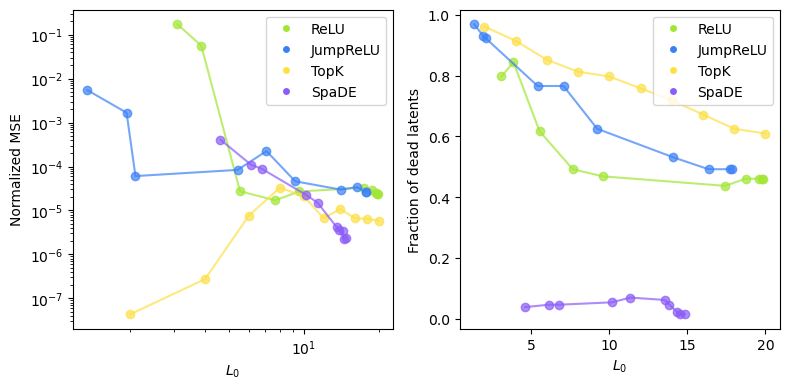

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
#choose 4 colors from a cmap
# cmap = plt.get_cmap('Set2')
# colors_sae = [cmap(i/len(saeorder)) for i in range(len(saeorder))]
colors_sae = ['#A2E634', '#3B81F6', '#FDE046', '#8B5CF7']

ax = axes[0]
for saetype in saeorder:
    indices = [i for i in range(len(exptnames)) if saetypes[i] == saetype]
    l0_vals = torch.tensor([l0_all[i] for i in indices])
    mse_vals = torch.tensor([mse_all[i]/datavar for i in indices])
    l0sortindices = np.argsort(l0_vals).squeeze()

    ax.plot(l0_vals[l0sortindices], mse_vals[l0sortindices], marker='o', linestyle='-', color=colors_sae[saeorder.index(saetype)], alpha=0.7)

#custom legend only showing the 4 colors
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=saenames_plot[i], markerfacecolor=colors_sae[i], markersize=6) for i in range(len(saenames_plot))]
ax.legend(handles=legend_elements, loc='upper right')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$L_0$')
ax.set_ylabel('Normalized MSE')

ax = axes[1]
for saetype in saeorder:
    indices = [i for i in range(len(exptnames)) if saetypes[i] == saetype]
    l0_vals = torch.tensor([l0_all[i] for i in indices])
    numdead = torch.tensor([numdeadlatents_all[i]/width for i in indices])
    l0sortindices = np.argsort(l0_vals).squeeze()

    ax.plot(l0_vals[l0sortindices], numdead[l0sortindices], marker='o', linestyle='-', color=colors_sae[saeorder.index(saetype)], alpha=0.7)

#custom legend only showing the 4 colors
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=saenames_plot[i], markerfacecolor=colors_sae[i], markersize=6) for i in range(len(saenames_plot))]
ax.legend(handles=legend_elements, loc='upper right')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$L_0$')
ax.set_ylabel('Fraction of dead latents')

plt.tight_layout()

In [ ]:
#compute stable ranks of data-data correlations; takes a while to run, so saved
stableranksdata = []
stablerankslatent = []

for i in range(len(exptnames)):
    srd = torch.trace(Cdatacos[i])/torch.linalg.matrix_norm(Cdatacos[i], ord=2)
    stableranksdata.append(srd.item())

    srl = torch.trace(Clatentcos[i])/torch.linalg.matrix_norm(Clatentcos[i], ord=2)
    stablerankslatent.append(srl.item())
    print(f'{exptnames[i]}: {srd.item()}, {srl.item()}')

In [ ]:
stableranksdata = torch.tensor(stableranksdata)
stablerankslatent = torch.tensor(stablerankslatent)

# stableranks = torch.load('./results_analysis/stableranks.pt')
# stableranksdata = stableranks['stableranksdata']
# stablerankslatent = stableranks['stablerankslatent']

torch.save({'stableranksdata': stableranksdata, 'stablerankslatent': stablerankslatent}, \
    './results_analysis/stableranks.pt')

/tmp/ipykernel_3596030/1190305883.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stableranks = torch.load('./results_analysis/stableranks.pt')


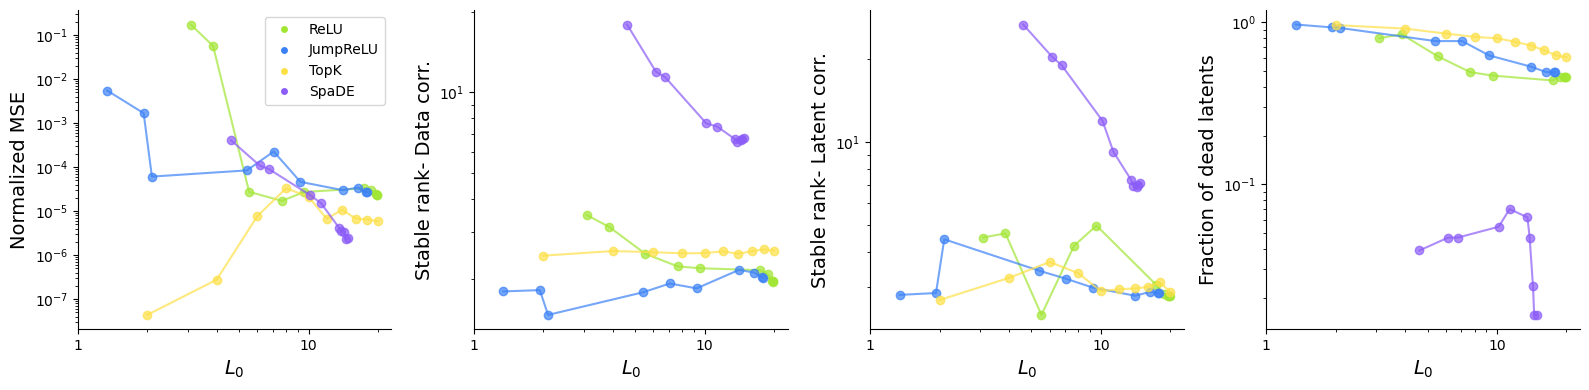

In [ ]:
#plot normalized MSE, stable rank of data and latent correlations, and fraction of dead latents

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

#plot normalized MSE vs sparsity
ax = axes[0]
for saetype in saeorder:
    indices = [i for i in range(len(exptnames)) if saetypes[i] == saetype]
    l0_vals = torch.tensor([l0_all[i] for i in indices])
    mse_vals = torch.tensor([mse_all[i]/datavar for i in indices])
    l0sortindices = np.argsort(l0_vals).squeeze()
    ax.plot(l0_vals[l0sortindices], mse_vals[l0sortindices], marker='o', linestyle='-', color=colors_sae[saeorder.index(saetype)], alpha=0.7)

#custom legend only showing the 4 colors
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=saenames_plot[i], markerfacecolor=colors_sae[i], markersize=6) for i in range(len(saenames_plot))]
ax.legend(handles=legend_elements, loc='upper right')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$L_0$', fontsize=14)
ax.set_ylabel('Normalized MSE', fontsize=14)

# plot fraction of dead latents
ax = axes[3]
for saetype in saeorder:
    indices = [i for i in range(len(exptnames)) if saetypes[i] == saetype]
    l0_vals = torch.tensor([l0_all[i] for i in indices])
    numdead = torch.tensor([numdeadlatents_all[i]/width for i in indices])
    l0sortindices = np.argsort(l0_vals).squeeze()

    ax.plot(l0_vals[l0sortindices], numdead[l0sortindices], marker='o', linestyle='-', color=colors_sae[saeorder.index(saetype)], alpha=0.7)

#custom legend only showing the 4 colors
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=saenames_plot[i], markerfacecolor=colors_sae[i], markersize=6) for i in range(len(saenames_plot))]
# ax.legend(handles=legend_elements, loc='upper right')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$L_0$', fontsize=14)
ax.set_ylabel('Fraction of dead latents', fontsize=14)

# plot stable rank of data correlations (obtained using sparse code)
ax = axes[1]
for saetype in saeorder:
    indices = [i for i in range(len(exptnames)) if saetypes[i] == saetype]
    l0_vals = torch.tensor([l0_all[i] for i in indices])
    srdata = torch.tensor([stableranksdata[i] for i in indices])
    l0sortindices = np.argsort(l0_vals).squeeze()

    ax.plot(l0_vals[l0sortindices], srdata[l0sortindices], marker='o', linestyle='-', color=colors_sae[saeorder.index(saetype)], alpha=0.7)

#custom legend only showing the 4 colors
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=saenames_plot[i], markerfacecolor=colors_sae[i], markersize=6) for i in range(len(saenames_plot))]
# ax.legend(handles=legend_elements, loc='upper right')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$L_0$', fontsize=14)
ax.set_ylabel('Stable rank- Data corr.', fontsize=14)

# plot stable rank of latent correlations (obtained using sparse code)
ax = axes[2]
for saetype in saeorder:
    indices = [i for i in range(len(exptnames)) if saetypes[i] == saetype]
    l0_vals = torch.tensor([l0_all[i] for i in indices])
    srlatent = torch.tensor([stablerankslatent[i] for i in indices])
    l0sortindices = np.argsort(l0_vals).squeeze()

    ax.plot(l0_vals[l0sortindices], srlatent[l0sortindices], marker='o', linestyle='-', color=colors_sae[saeorder.index(saetype)], alpha=0.7)

#custom legend only showing the 4 colors
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=saenames_plot[i], markerfacecolor=colors_sae[i], markersize=6) for i in range(len(saenames_plot))]
# ax.legend(handles=legend_elements, loc='upper right')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$L_0$', fontsize=14)
ax.set_ylabel('Stable rank- Latent corr.', fontsize=14)

for ax in axes.flatten():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

#add xticks at 5e0, 10 for all axes
for ax in axes.flatten():
    ax.set_xticks([1, 10])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.tight_layout()
# plt.savefig('./figs/appendix_sep_nmse.pdf', bbox_inches='tight', dpi=300)

In [13]:
numdeadlatents_all= torch.tensor(numdeadlatents_all)

Text(0.45, 0.06, 'Latent rep.')

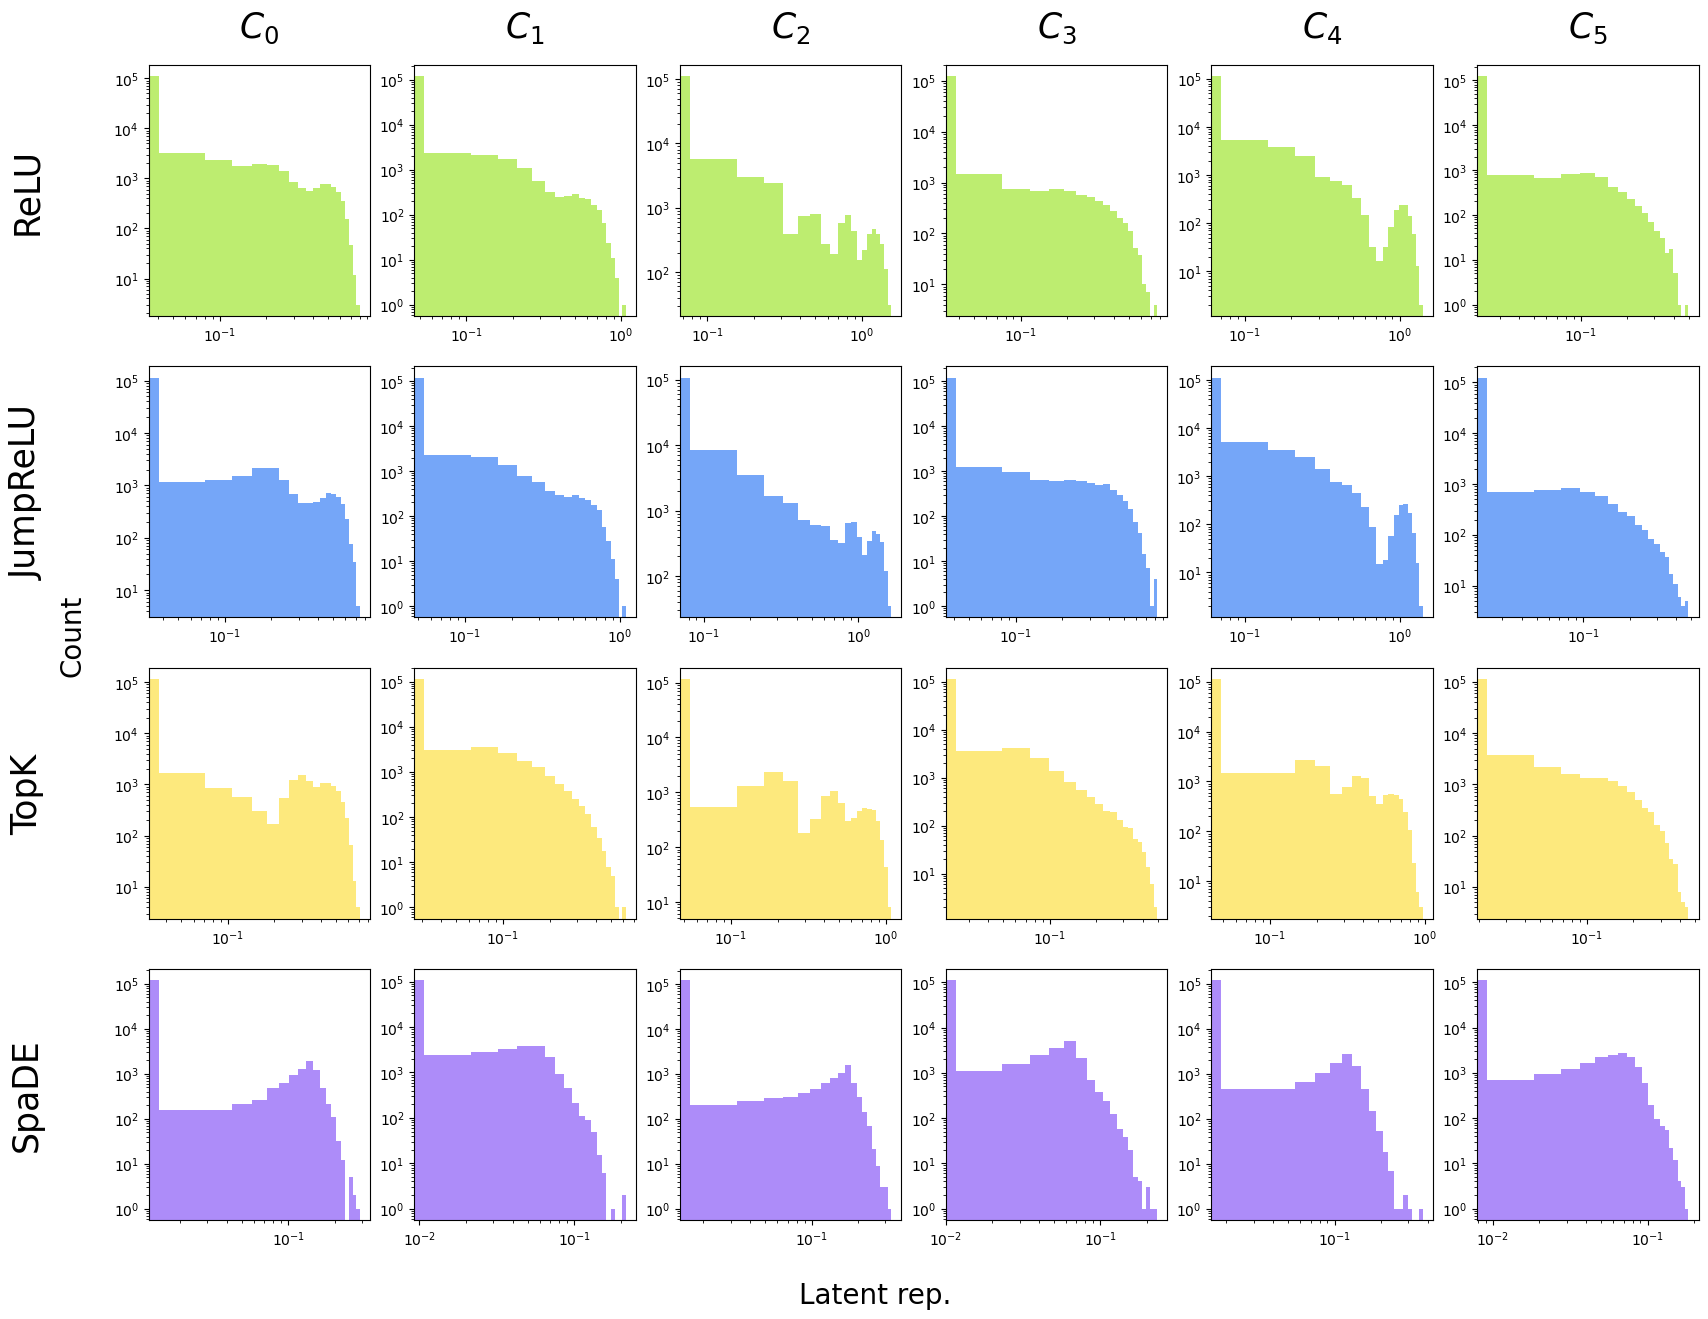

In [14]:
#plot histograms of latent reps for each concept and each sae- in a big 4 X 6 plot

fig, ax = plt.subplots(4, 6, figsize=(20, 15))
for i in range(len(exptnames)):
    if i not in plot_indices:
        continue
    rowid = saeorder.index(saetypes[i])
    for c in range(num_concepts):

        ax[rowid, c].hist(latent_reps_all[i][labels_subset==c,:].flatten(), bins=20, alpha=0.7, color=colors_sae[saeorder.index(saetypes[i])])
        if rowid == 0:
            ax[rowid, c].set_title(f'$C_{c}$', fontsize=25, pad=20)
        if c==0:
            ax[rowid, c].set_ylabel(saenames_plot[rowid], fontsize=25, labelpad=50)
        ax[rowid, c].set_yscale('log')
        ax[rowid, c].set_xscale('log')
# Add a single y-axis label for all rows
fig.text(0.08, 0.5, "Count", va='center', rotation='vertical', fontsize=20)
fig.text(0.45, 0.06, "Latent rep.", va='center', rotation='horizontal', fontsize=20)


# plt.savefig('./figs/appendix_separability_latenthist.pdf', bbox_inches='tight', dpi=300)

In [15]:
[exptnames[plot_indices[i]] for i in range(len(plot_indices))]

['still801_relu_gamreg0.0001_w128_021725',
 'most486_jumprelu_gamreg0.0001_w128_021725',
 'guava893_topk_relu_k18_w128_021725',
 'satin51_spade_gamreg0.0005_w128_021725']

In [ ]:
#latent correlations of only active latents (non-dead)
Clatentcos_active = []

for i in range(len(exptnames)):
    deadrows = Clatentcos[i].sum(dim=0) <1e-10
    cmat = Clatentcos[i][:,~deadrows]
    cmat = cmat[~deadrows,:]
    Clatentcos_active.append(cmat)

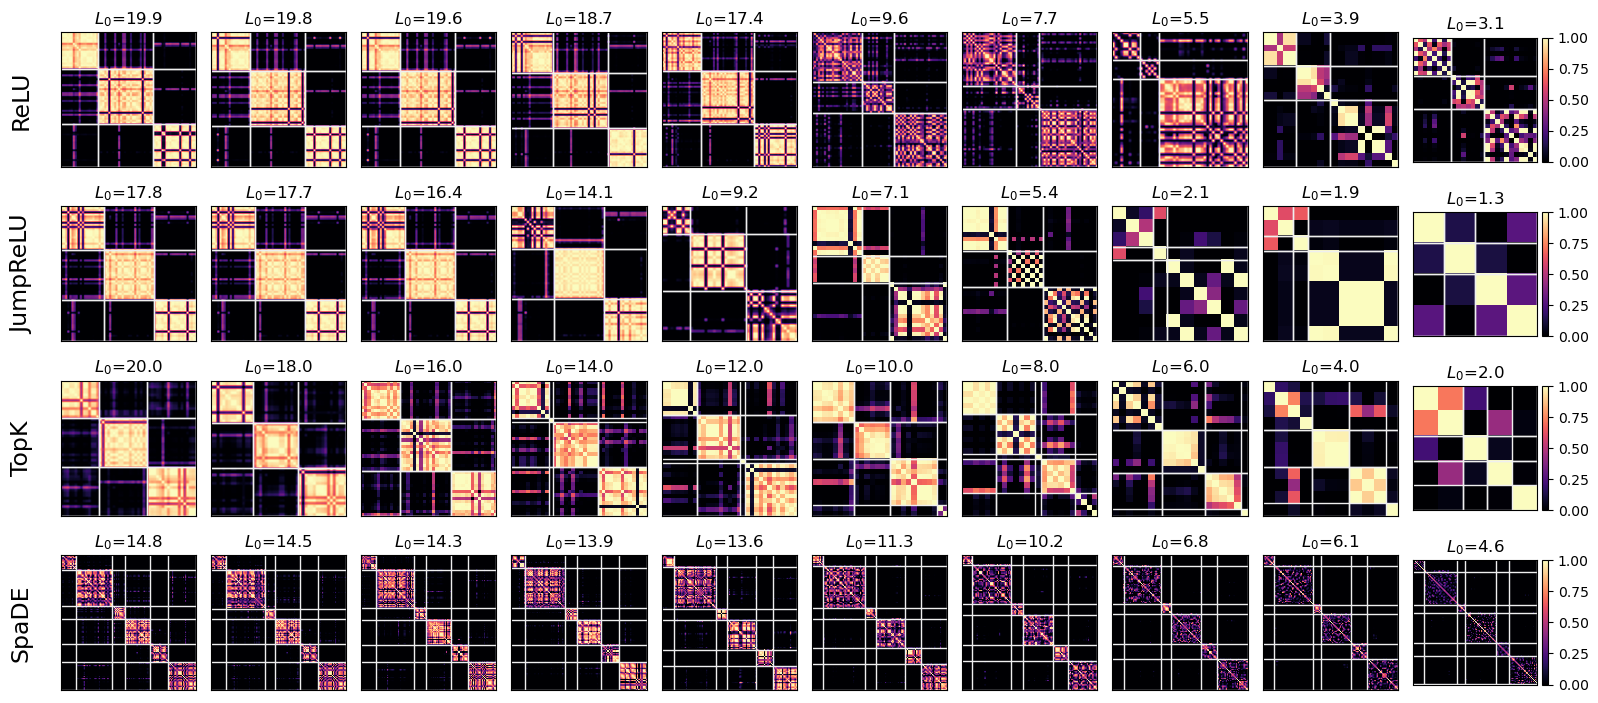

In [ ]:
#plot latent correlations of only active latents (non-dead)
from mpl_toolkits.axes_grid1 import make_axes_locatable

kvalues_order = sorted(kvals_plot, reverse=True)
gammavals_relu_order = sorted(gammavals_relu_plot)
gammavals_jumprelu_order = sorted(gammavals_jumprelu_plot)
gammavals_spade_order = sorted(gammavals_spade_plot)
fig, ax = plt.subplots(len(set(saetypes)), 10, figsize=(1.6*10, 1.6*4.5))
for i in range(len(exptnames)):
    if saetypes[i]!='topk_relu':
        if saetypes[i]=='relu':
            gammvals = gammavals_relu_order
        elif saetypes[i]=='jumprelu':
            gammvals = gammavals_jumprelu_order
        elif saetypes[i]=='sparsemax_dist':
            gammvals = gammavals_spade_order
        gami = float(exptnames[i].split('gamreg')[1].split('_')[0])
        loc = gammvals.index(gami)
    else:
        kval_i = int(exptnames[i].split('topk_relu_k')[1].split('_')[0])
        loc = kvalues_order.index(kval_i)
    
    rowid = saeorder.index(saetypes[i])
    heatmap = ax[rowid, loc].imshow(Clatentcos_active[i].cpu(), cmap='magma', vmin=0, vmax=1, extent=[0, Clatentcos_active[i].shape[0], Clatentcos_active[i].shape[1],0])
    concepts_now = concepts_of_latents_all[i][order_by_concept_all[i]]
    numlatents_perconc = [torch.sum(concepts_now==j).item() for j in range(num_concepts)]
    latentconcboundarylocs = np.cumsum(numlatents_perconc)
    ax[rowid, loc].hlines(latentconcboundarylocs, 0, Clatentcos_active[i].shape[0], colors='#EFEFEF', linewidth=1)
    ax[rowid, loc].vlines(latentconcboundarylocs, 0, Clatentcos_active[i].shape[1], colors='#EFEFEF',linewidth=1)
    
    # ax[rowid, loc].set_title(exptnames[i])
    if loc==0:
        ax[rowid, 0].set_ylabel(saenames_plot[saeorder.index(saetypes[i])], fontsize=17, labelpad=20)
    # if rowid==0:
    # if saetypes[i]=='topk_relu':
    #     ax[rowid, loc].set_title(f"k={kval_i}")
    # else:
    ax[rowid, loc].set_title(f"$L_0$={l0_all[i].item():.1f}")
    ax[rowid, loc].set_xticks([])
    ax[rowid, loc].set_yticks([])
    if loc==9:
        divider = make_axes_locatable(ax[rowid, loc])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(heatmap, cax=cax, orientation='vertical')
# fig.text(0.08, 0.5, "Count", va='center', rotation='vertical', fontsize=20)
# fig.text(0.45, 0.06, "Latent rep.", va='center', rotation='horizontal', fontsize=20)

plt.tight_layout()
#reduce white spaces
# plt.subplots_adjust(wspace=0.01, hspace=0.01)
# plt.savefig('./figs/appendix_sep_latentcorr.pdf', bbox_inches='tight', dpi=300)

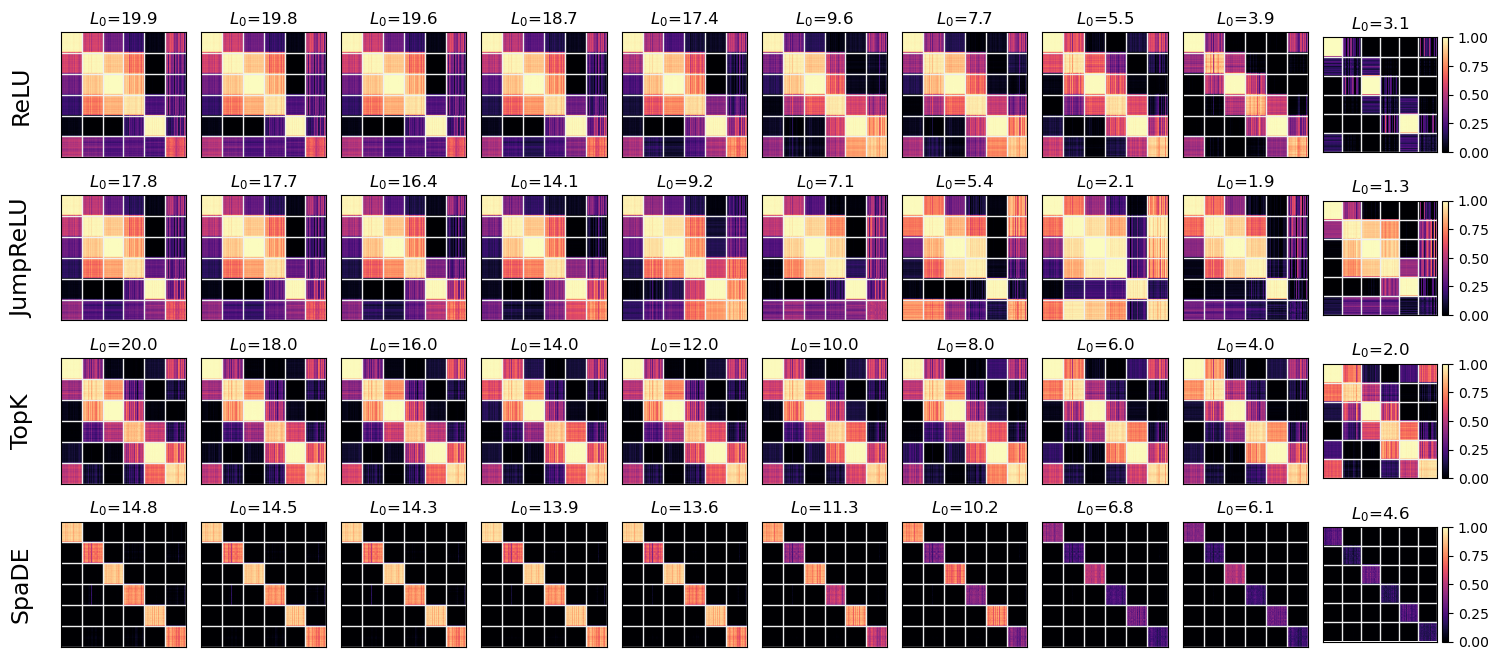

In [ ]:
#plot data correlations (similarity between sparse codes of pairs of data points)
kvalues_order = sorted(kvals_plot, reverse=True)
gammavals_relu_order = sorted(gammavals_relu_plot)
gammavals_jumprelu_order = sorted(gammavals_jumprelu_plot)
gammavals_spade_order = sorted(gammavals_spade_plot)
fig, ax = plt.subplots(len(set(saetypes)), 10, figsize=(1.5*10, 1.5*4.5))
for i in range(len(exptnames)):
    if saetypes[i]!='topk_relu':
        if saetypes[i]=='relu':
            gammvals = gammavals_relu_order
        elif saetypes[i]=='jumprelu':
            gammvals = gammavals_jumprelu_order
        elif saetypes[i]=='sparsemax_dist':
            gammvals = gammavals_spade_order
        gami = float(exptnames[i].split('gamreg')[1].split('_')[0])
        loc = gammvals.index(gami)
    else:
        kval_i = int(exptnames[i].split('topk_relu_k')[1].split('_')[0])
        loc = kvalues_order.index(kval_i)
    
    rowid = saeorder.index(saetypes[i])
    height, widthcdata = Cdatacos[i].shape
    datacorr = ax[rowid, loc].imshow(Cdatacos[i].cpu(), cmap='magma', vmin=0, vmax=1, extent=[0, widthcdata, height, 0])
    ax[rowid, loc].vlines([numpoints_perconcept*j for j in range(1, num_concepts+1)],
                    0, height, color='#EFEFEF', linewidth=1)
    ax[rowid, loc].hlines([numpoints_perconcept*j for j in range(1, num_concepts+1)],
                    0, widthcdata, color='#EFEFEF', linewidth=1)
    
    # ax[rowid, loc].set_title(exptnames[i])
    if loc==0:
        ax[rowid, 0].set_ylabel(saenames_plot[saeorder.index(saetypes[i])], fontsize=17, labelpad=20)
    # if rowid==0:
    # if saetypes[i]=='topk_relu':
    #     ax[rowid, loc].set_title(f"k={kval_i}")
    # else:
    ax[rowid, loc].set_title(f"$L_0$={l0_all[i].item():.1f}")
    ax[rowid, loc].set_xticks([])
    ax[rowid, loc].set_yticks([])
    if loc==9:
        divider = make_axes_locatable(ax[rowid, loc])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(datacorr, cax=cax, orientation='vertical')

# fig.text(0.08, 0.5, "Count", va='center', rotation='vertical', fontsize=20)
# fig.text(0.45, 0.06, "Latent rep.", va='center', rotation='horizontal', fontsize=20)

plt.tight_layout()
# plt.savefig('./figs/appendix_sep_datacorr.pdf', bbox_inches='tight', dpi=300)